<img src="./images/DLI_Header.png" style="width: 400px;">

# 모델 배포
이제 제대로 트레이닝한 모델을 사용해 보겠습니다. 이 연습에서는 모델에 새 이미지를 노출시키고 수화 알파벳의 올바른 문자를 검출할 것입니다. 시작하겠습니다!

## 목표

* 이미 트레이닝된 모델을 디스크에서 로드
* 다른 형식의 이미지에 대해 트레이닝된 모델의 이미지 형식 변경
* 트레이닝된 모델이 처음 접하는 새로운 이미지로 추론을 수행하고 성능을 평가

## 모델 로드
새 노트북을 시작했으니 트레이닝한 저장된 모델을 로드해 보겠습니다. 이전 연습에서 저장했을 때는 "asl_model"이라는 폴더가 생성되었습니다. 같은 폴더를 선택하여 모델을 로드할 수 있습니다.

In [2]:
from tensorflow import keras

model = keras.models.load_model('asl.h5')

2023-01-29 14:22:46.183537: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


모든 것이 그대로 보이도록 하고 싶은 경우 모델 요약을 다시 확인할 수 있습니다.

In [3]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 50)         

## 모델을 위한 이미지 준비

이제 모델을 사용하여 처음 접하는 새 이미지에 대한 예측을 수행해야 합니다. 이를 추론이라고 부릅니다. asl_images 폴더에는 이미지 세트가 주어져 있습니다. 왼쪽 탐색을 사용하여 폴더를 연 다음 이미지를 살펴보십시오.

이 이미지는 데이터세트의 이미지보다 해상도가 훨씬 높다는 것을 알 수 있습니다. 또한 컬러로 되어 있습니다. 데이터세트의 이미지는 28x28픽셀의 회색조였음을 기억하십시오. 모델로 예측을 수행할 때마다 입력은 모델이 트레이닝된 데이터의 모양과 일치해야 한다는 점을 명심해야 합니다. 이 모델의 경우 트레이닝 데이터세트의 모양은 (27455, 28, 28, 1)이었습니다. 이는 각각 하나의 색상 채널(회색조)을 지닌 28x28픽셀의 이미지 27,455개에 해당합니다. 

### 이미지 표시

모델을 사용하여 새 이미지에 대한 예측을 수행하는 경우에는 이미지를 표시하는 것도 도움이 됩니다. matplotlib 라이브러리를 사용하여 이렇게 할 수 있습니다.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

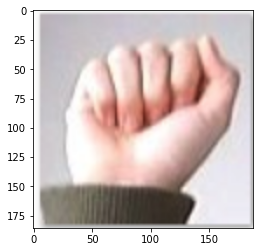

In [8]:
show_image('data/asl_image/a.png')

### 이미지 확장

데이터세트의 이미지는 28x28픽셀이고 회색조(Grayscale)였습니다. 예측을 위해서는 크기와 색상이 동일한 이미지를 메서드에 전달해야 합니다. Python으로 이미지를 편집할 수 있는 몇 가지 방법이 있지만 Keras에는 성능이 뛰어난 유틸리티가 내장되어 있습니다. 

In [6]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

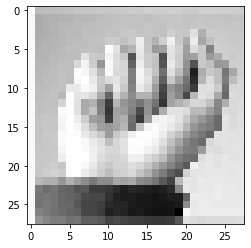

In [7]:
image = load_and_scale_image('data/asl_image/a.png')
plt.imshow(image, cmap='gray')

### 예측을 위한 이미지 준비

28x28픽셀 회색조 이미지가 준비되었으니 이제 곧 예측을 위해 이를 모델 안으로 전달할 수 있습니다. 우선 모델이 트레이닝된 데이터세트의 모양과 일치하도록 이미지를 재구성해야 합니다. 재구성이 가능하려면 먼저 이미지를 좀 더 기본적인 형식으로 변환해야 합니다. 이를 위해 image_to_array라는 Keras 유틸리티를 사용하겠습니다.

In [9]:
image = image_utils.img_to_array(image)

이제 예측을 위한 준비가 되도록 이미지를 재구성할 수 있습니다.

In [10]:
# This reshape corresponds to 1 image of 28x28 pixels with one color channel
image = image.reshape(1,28,28,1)
image.shape

(1, 28, 28, 1)

마지막으로, 트레이닝 데이터세트로 했던 것처럼 데이터를 정규화(모든 값을 0~1로 설정)해야 합니다.

In [11]:
image = image / 255

## 예측 수행

자, 이제 예측할 준비가 되었습니다! 사전 처리된 이미지를 모델의 예측 메서드에 전달하면 예측 준비가 완료됩니다. 

In [13]:
prediction = model.predict(image)
print(prediction)

[[8.1265891e-01 2.4252095e-21 3.5590250e-19 2.6137025e-25 1.9543445e-15
  1.2981944e-15 4.6099956e-25 1.1805003e-16 6.7155105e-12 3.1320371e-25
  8.6063635e-18 2.2008409e-10 1.8734109e-01 2.1279258e-18 1.0176959e-19
  1.2487759e-22 2.2417870e-30 4.3572534e-10 1.3690149e-20 8.2778518e-27
  4.9047273e-27 2.0131847e-15 9.9258917e-22 6.3818650e-10]]


### 예측 이해

예측은 24 길이 어레이의 형식을 취합니다. 약간 달라 보이긴 하지만 이는 y_train 및 y_test의 "바이너리화된" 범주 어레이와 동일한 형식입니다. 어레이의 각 엘리먼트는 각 범주의 컨피던스를 표현하는 0~1 사이의 확률입니다. 좀 더 읽기 쉽게 만들어 보겠습니다. 우선 어레이의 어떤 엘리먼트가 가장 높은 확률을 나타내는지부터 찾아볼 수 있습니다. NumPy 라이브러리와 [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) 함수를 사용하여 쉽게 찾을 수 있습니다.

In [14]:
import numpy as np
np.argmax(prediction)

0

예측 어레이의 각 엘리먼트는 수화 알파벳의 가능한 문자를 나타냅니다. 전에 얘기했듯이 j와 z는 손을 움직여야 하기 때문에 옵션에서 제외됩니다. 여기서는 정지 이미지만 다루고 있습니다. 예측 어레이의 인덱스와 해당하는 문자 간의 매핑을 생성해 보겠습니다. 

In [25]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"
dictionary = {}
for i in range(24):
    dictionary[i] = alphabet[i]
dictionary

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'k',
 10: 'l',
 11: 'm',
 12: 'n',
 13: 'o',
 14: 'p',
 15: 'q',
 16: 'r',
 17: 's',
 18: 't',
 19: 'u',
 20: 'v',
 21: 'w',
 22: 'x',
 23: 'y'}

이제 예측 인덱스를 전달하여 해당하는 문자를 찾을 수 있습니다.

In [26]:
dictionary[np.argmax(prediction)]

'a'

## 연습: 전부 취합하기

이미지 파일로만 예측을 수행할 수 있도록 모든 요소를 함수에 넣어 보겠습니다. 위의 함수와 단계를 사용하여 아래 함수에 구현하십시오. 도움이 필요한 경우 아래의 점 세 개를 클릭하여 솔루션을 표시할 수 있습니다.

In [27]:

def predict_letter(file_path):
    show_image(file_path)
    image = load_and_scale_image(file_path)
    image = image_utils.img_to_array(image)
    image = image.reshape(1,28,28,1) 
    image = image/255
    prediction = model.predict(image)
    # convert prediction to letter
    predicted_letter = dictionary[np.argmax(prediction)]
    return predicted_letter

## 솔루션

아래의 '...'를 클릭하면 솔루션이 표시됩니다.

```python
def predict_letter(file_path):
    show_image(file_path)
    image = load_and_scale_image(file_path)
    image = image_utils.img_to_array(image)
    image = image.reshape(1,28,28,1) 
    image = image/255
    prediction = model.predict(image)
    # convert prediction to letter
    predicted_letter = dictionary[np.argmax(prediction)]
    return predicted_letter
```

'b'

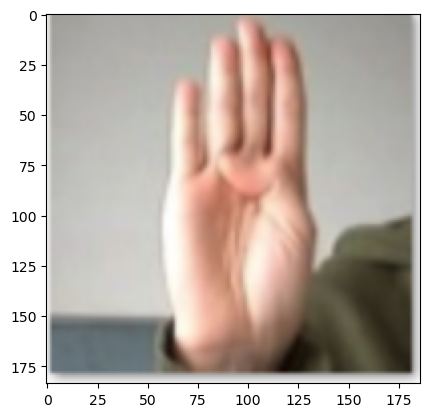

In [28]:
predict_letter("data/asl_image/b.png")

또한 asl_images 데이터세트에서 'a' 문자에 함수를 사용해보겠습니다.

'a'

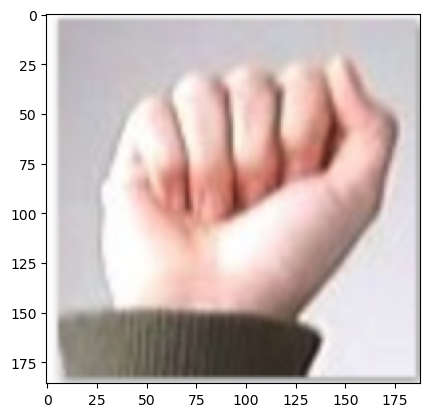

In [29]:
predict_letter("data/asl_image/a.png")

## 요약

잘하셨습니다! 매우 정확한 모델을 처음부터 트레이닝한 다음 모델을 사용하여 새롭고 중요한 예측을 수행하는 전체 과정을 거쳤습니다. 시간적 여유가 있다면 웹캠으로 사진을 촬영하고 asl_data 폴더에 넣어 업로드한 다음 해당 사진에 대해 모델을 테스트해 보십시오. Mac의 경우 Photo Booth를 사용할 수 있습니다. Windows의 경우 시작 화면에서 카메라 앱을 선택할 수 있습니다. 테스트해 보시기 바랍니다. 이는 수화에 대해 알아볼 수 있는 좋은 기회입니다! 예를 들면 본인 이름에 들어가는 문자를 시험해 보십시오.

이 모델을 애플리케이션에서 잘 활용하면 누군가에게 수화를 가르치거나, 말을 할 수 없는 누군가가 컴퓨터와 상호 작용하도록 도울 수도 있을 것입니다. 웹 개발이 익숙한 경우에는 [TensorFlow.js](https://www.tensorflow.org/js)라는 라이브러리를 사용하여 모델을 브라우저에서 사용할 수도 있습니다.

## 메모리 지우기

넘어가기 전에 다음 셀을 실행하여 GPU 메모리를 지워주시기 바랍니다.

In [13]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## 다음

연습이 즐거우셨기를 바랍니다! 다음 섹션에서는 견고한 데이터세트가 없을 때 딥러닝을 활용하는 방법에 대해 알아보겠습니다. 다음 섹션에서 뵙겠습니다!
엣지에서의 추론을 자세히 알아보고 싶은 경우에는 해당 주제에 관한 [이 우수 논문](https://research.fb.com/wp-content/uploads/2018/12/Machine-Learning-at-Facebook-Understanding-Inference-at-the-Edge.pdf)을 참조하십시오.

자체 모델을 빌드하는 것이 익숙해졌고 원리를 어느 정도 이해했으니 이제 사전 트레이닝된 모델을 사용하여 작업을 촉진하는 매우 강력한 기술을 살펴보겠습니다. 이어서 다음 노트북인 [*사전 트레이닝된 모델*](./05a_doggy_door.ipynb)을 계속 진행해 주십시오.